# Response time minimization - Trøndelag police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


In [14]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-18T15:07:07.955911+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.1
pandana   : 0.7
osmnx     : 1.9.1
numpy     : 1.26.4
matplotlib: 3.8.3
geopandas : 0.14.3



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [16]:
### Load road network from file
Trondelag_filepath = "../data/Trondelag/TrondelagDriveImputed.graphml" # with travel time attribute
Trondelag_graph = ox.load_graphml(Trondelag_filepath) # originally in WGS84 (EPSG:4326)

In [17]:
Trondelag_graph = ox.projection.project_graph(Trondelag_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Trondelag_graph: {type(Trondelag_graph)}")
print(f"CRS of Trondelag_graph:  {Trondelag_graph.graph['crs']}")

# # plot graph
# fig, ax = ox.plot_graph(Trondelag_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Trondelag_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Trondelag_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [18]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Trondelag_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid                      highway  \
u       v          key                                                        
9855546 8332068274 0                  23735591                  residential   
        8332068278 0    [723741010, 373622063]  [unclassified, residential]   

                        maxspeed  oneway reversed  length  \
u       v          key                                      
9855546 8332068274 0          30   False    False  90.212   
        8332068278 0    [20, 40]   False    False 204.226   

                                                                 geometry  \
u       v          key                                                      
9855546 8332068274 0    LINESTRING (227314.152 6951415.696, 227308.701...   
        8332068278 0    LINESTRING (227314.152 6951415.696, 227326.669...   

                        speed_kph  travel_time             name  ref bridge  \
u       v          key                                                        
9855546 8332068274 0       30.000       10.800              NaN  NaN    NaN   
        8332068278 0       30.000       24.500  Ola Setroms veg  NaN    NaN   

                       lanes width junction access tunnel est_width  
u       v          key                                               
9855546 8332068274 0     NaN   NaN      NaN    NaN    NaN       NaN  
        8332068278 0     NaN   NaN      NaN    NaN    NaN       NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [19]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid                      highway  \
u       v          key                                                        
9855546 8332068274 0                  23735591                  residential   
        8332068278 0    [723741010, 373622063]  [unclassified, residential]   

                        maxspeed  oneway reversed  length  \
u       v          key                                      
9855546 8332068274 0          30   False    False  90.212   
        8332068278 0    [20, 40]   False    False 204.226   

                                                                 geometry  \
u       v          key                                                      
9855546 8332068274 0    LINESTRING (227314.152 6951415.696, 227308.701...   
        8332068278 0    LINESTRING (227314.152 6951415.696, 227326.669...   

                        speed_kph  travel_time             name  ref bridge  \
u       v          key                                                        
9855546 8332068274 0       35.900        9.046              NaN  NaN    NaN   
        8332068278 0       35.900       20.479  Ola Setroms veg  NaN    NaN   

                       lanes width junction access tunnel est_width  
u       v          key                                               
9855546 8332068274 0     NaN   NaN      NaN    NaN    NaN       NaN  
        8332068278 0     NaN   NaN      NaN    NaN    NaN       NaN

In [20]:
# recombining nodes and increased edges to MultiDiGraph format
Trondelag_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [21]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Trondelag_polygon_path = "../data/Trondelag/TrondelagCombinedPolygon.geojson"
Trondelag_polygon_gdf = gpd.read_file(Trondelag_polygon_path)
Trondelag_polygon_gdf = Trondelag_polygon_gdf.to_crs(Trondelag_graph.graph['crs']) # convert to same CRS as the road network

In [22]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Trondelag/TrondelagPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Trondelag_graph.graph['crs']) # convert to same CRS as the road network

In [23]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  22205006920000           1   
1  22217506934000           2   

                                            geometry  
0  POLYGON ((220500.000 6920000.000, 220500.000 6...  
1  POLYGON ((221750.000 6934000.000, 221750.000 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [30]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1100) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=2700, max_range=2800) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 2748. Target range [2700, 2800], using population multiplier: 0.008347656250000002


id  population  \
20079  22717507042250        1088   
6983   22697507041750         846   
6997   22715007042000         790   

                                                geometry  num_points  
20079  POLYGON ((271750.000 7042250.000, 271750.000 7...           9  
6983   POLYGON ((269750.000 7041750.000, 269750.000 7...           7  
6997   POLYGON ((271500.000 7042000.000, 271500.000 7...           7

In [31]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (223035.454 6945212.075)
1  POINT (226110.520 6950536.683)
2  POINT (226436.075 6950647.897)

In [32]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=4.0e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 6.562e-71 | Median: 4.178e-13 | Mean: 2.092e-11 | Max: 1.682e-09


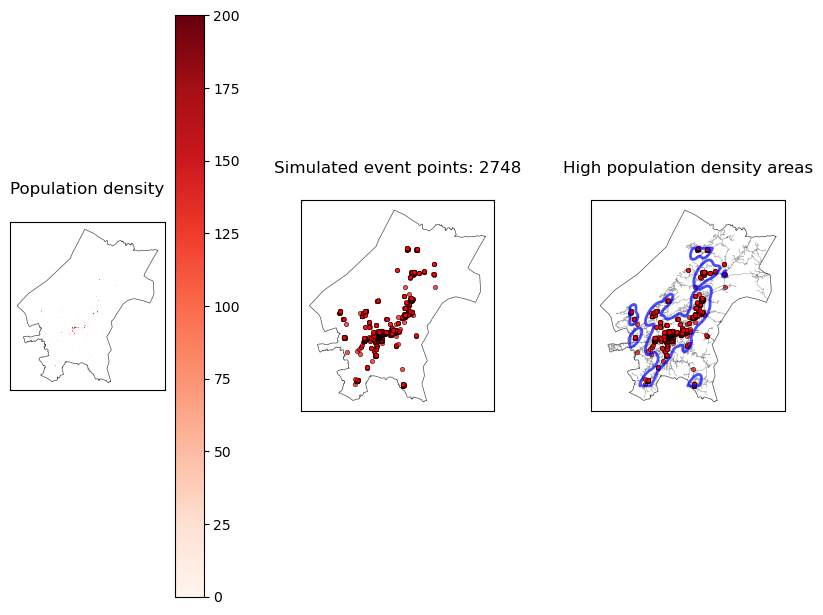

In [33]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Trondelag_polygon_gdf, population_gdf, 
                                                        event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [35]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Trondelag/TrondelagNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count   lon    lat highway  ref  \
osmid                                                                       
9855546    6951415.696 227314.152             4 9.686 62.592     NaN  NaN   
8332068274 6951488.260 227260.195             4 9.685 62.593     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
9855546     POINT (227314.152 6951415.696)                 0.000   
8332068274  POINT (227260.195 6951488.260)                 0.000   

            betweenness_centrality  
osmid                               
9855546                5163089.000  
8332068274             1186946.000

### 2.2 Sample candidate points and filter out best candidate points

In [37]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 25723, nr of police car nodes: 100


y          x  street_count    lon    lat highway  ref  \
osmid                                                                        
5079083681 7077776.551 336013.029             3 11.671 63.789     NaN  NaN   
5763500238 7070709.184 325243.850             3 11.461 63.720     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
5079083681  POINT (336013.029 7077776.551)                 0.000   
5763500238  POINT (325243.850 7070709.184)                 0.000   

            betweenness_centrality  
osmid                               
5079083681             1399542.000  
5763500238              281333.000

Input nr of car nodes: 100
Remaining nr of car nodes: 85, after discarding the 15 (15%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


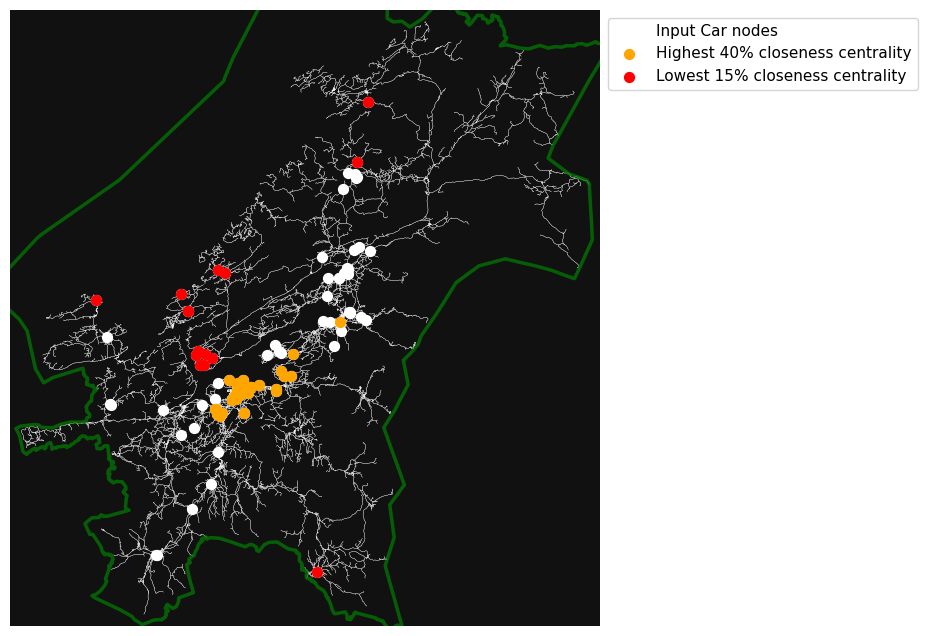

In [38]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Trondelag_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.15, input_graph=Trondelag_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 85
Remaining nr of car nodes: 68, after discarding the 17 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


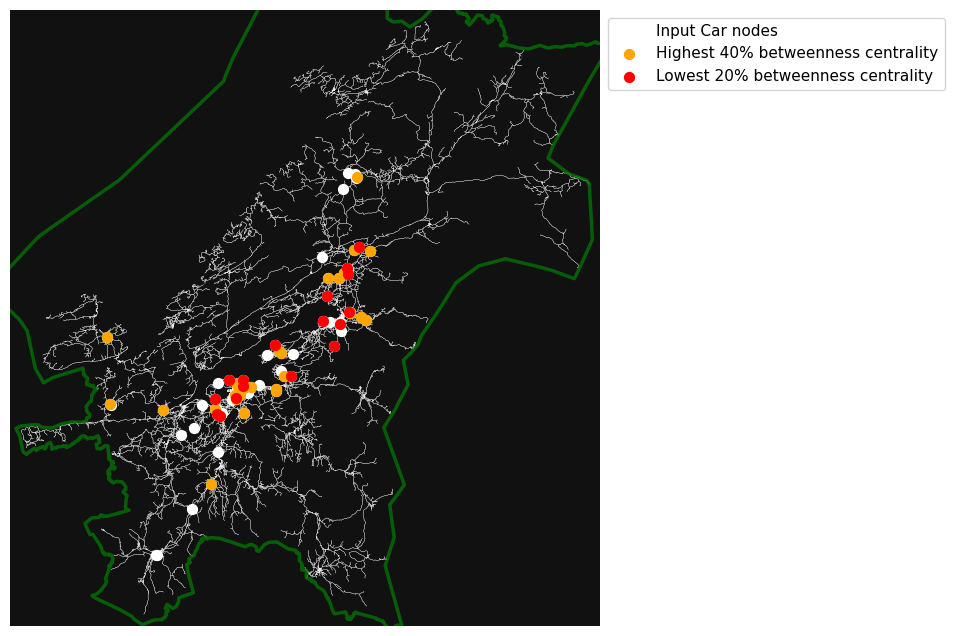

In [39]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Trondelag_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=Trondelag_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 68
Remaining nr of car nodes: 13, after removing the 55 nodes that are within 14000 m of each other



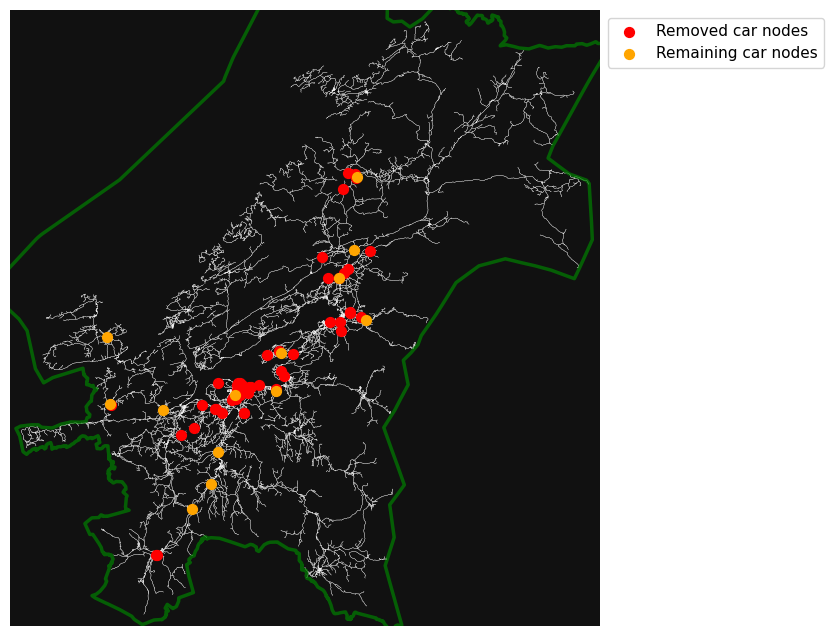

In [40]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Trondelag_polygon_gdf, 
                        min_distance=14000, input_graph=Trondelag_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [42]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
Trondelag_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Trondelag_network_pdna: {type(Trondelag_network_pdna)}")
print(f"Network nodes:")
Trondelag_network_pdna.nodes_df.head(2)

type of Trondelag_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
9855546    227314.152 6951415.696
8332068274 227260.195 6951488.260

In [43]:
print(f"Network edges: ")
Trondelag_network_pdna.edges_df.head(2)

Network edges: 


from          to  length  travel_time
0  9855546  8332068274  90.212        9.046
1  9855546  8332068278 204.226       20.479

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [45]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Trondelag_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y  \
0  POINT (223035.454 6945212.075)    8332061931 223022.694 6945201.068   
1  POINT (226110.520 6950536.683)    8332064053 226074.149 6950592.349   

   x_nearest_node  y_nearest_node  
0      223022.694     6945201.068  
1      226074.149     6950592.349

In [46]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Trondelag_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Trondelag_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([  10133781, 7339868590, 7339868531, 5880893084, 6029146495],
      dtype=int64)

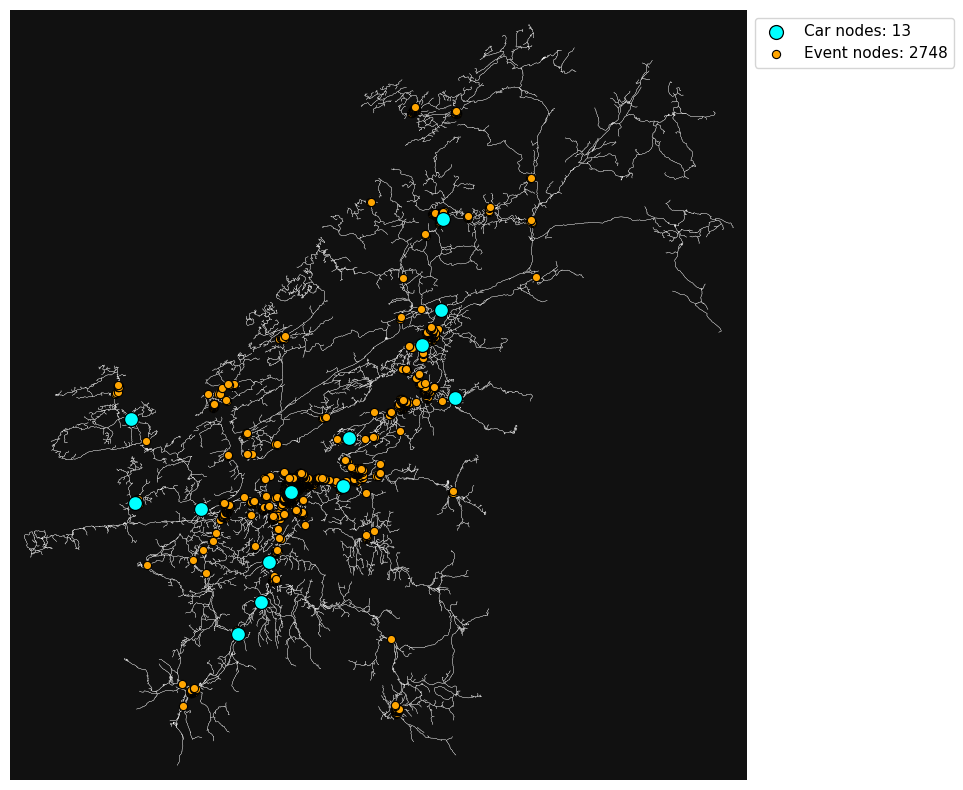

In [47]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Trondelag_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [49]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [50]:
%%time
# travel time between each possible pair of car-event combination
distances = Trondelag_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Trondelag_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

13 origins x 2748 destinations = 35724 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [119355.806, 113202.22, 112583.722, 112487.273, 112686.571]
5 first origin-destination travel times [sec]: [4591.315, 4386.529, 4353.831, 4346.775, 4383.4]
CPU times: total: 828 ms
Wall time: 120 ms


In [51]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count   mean    std   min    25%    50%    75%     max
0 35724.000 64.423 43.257 0.000 33.919 59.611 82.774 283.260

In [52]:
# Restructure the distances and travel times arrays into a DataFrame (CTrondelag Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID          x           y
0 119355.806     4591.315   10133781   8332061931 223022.694 6945201.068
1 113202.220     4386.529   10133781   8332064053 226074.149 6950592.349

In [53]:
# Save cTrondelag matrix to CSV
CostMatrix.to_csv("../data/Trondelag/TrondelagCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [54]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID   eventNodeID
0     4591.315   10133781  8332061931_1
1     4386.529   10133781  8332064053_1

In [56]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.04 # 4% of all events
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 797 events per car
Filtering out 0% highest travel times - keeping only travel times <= 16996 sec, or 283.3 min
Original nr of pairs: 35724 | Filtered nr of pairs: 35724
Original max travel time: 16995.613 | Filtered max travel time: 16995.613


### 5.2 Setup LP problem

In [57]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 13
Number of events: 2748
Number of decision variables: 35737
Number of constraints: 38486
Number of non-zero coefficients: 35737
Number of non-zero coefficients in the objective function: 35723
CPU times: total: 1.55 s
Wall time: 2.2 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).


In [58]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
Optimal police car locations found: 4/4 in 3.88 seconds: [  10133781 7339868590 8601568050 5834133164]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 3128805.5570 seconds, or 52146.76 minutes, or 869.11 hours
CPU times: total: 1.55 s
Wall time: 5.02 s


### 5.6 Extract results for inspection

In [59]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/Trondelag/TrondelagCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([10133781, 7339868590, 8601568050, 5834133164])
Car 10133781 is assigned 797/797 events
Car 7339868590 is assigned 509/797 events
Car 8601568050 is assigned 797/797 events
Car 5834133164 is assigned 645/797 events
Summing the events for each car gives 2748 events, which should equal the total number of unique events: 2748


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 13 | Optimal locations in solution: 4
- Events: 2748 | Max event capacity per police car: 797

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 3128806 sec | 52146.8 min | 869.11 hours

Car id: 10133781 handles 797 events | Capacity: 100.00% | Total response time: 3305.75 min | Median: 4.19 min | Avg: 4.15 min
Car id: 7339868590 handles 509 events | Capacity: 63.86% | Total response time: 20140.92 min | Median: 24.62 min | Avg: 39.57 min
Car id: 8601568050 handles 797 events | Capacity: 100.00% | Total response time: 9387.55 min | Median: 12.72 min | Avg: 11.78 min
Car id: 5834133164 handles 645 events | Capacity: 80.93% | Total response time: 19312.54 min | Median: 22.85 min | Avg: 29.94 min


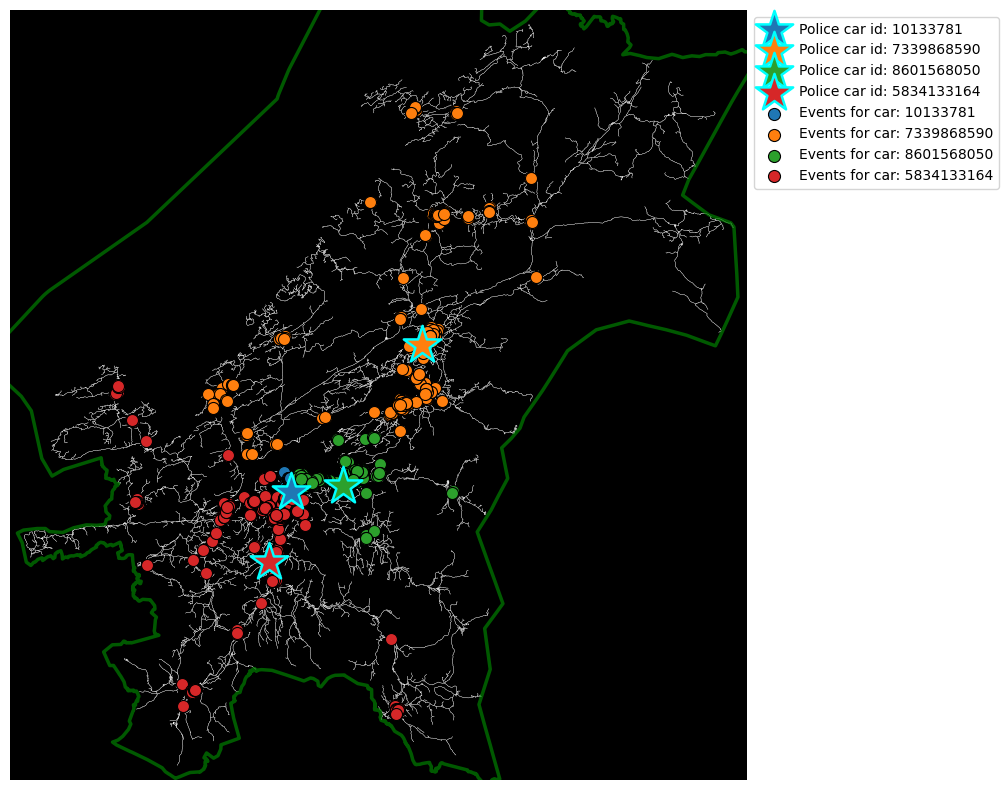

CPU times: total: 3.95 s
Wall time: 5.37 s


In [61]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(Trondelag_graph, Trondelag_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [66]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [67]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Trondelag_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=500, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 1min 41s
Wall time: 2min 3s


Isochrone polygons for the travel times: [20, 60, 120] minutes


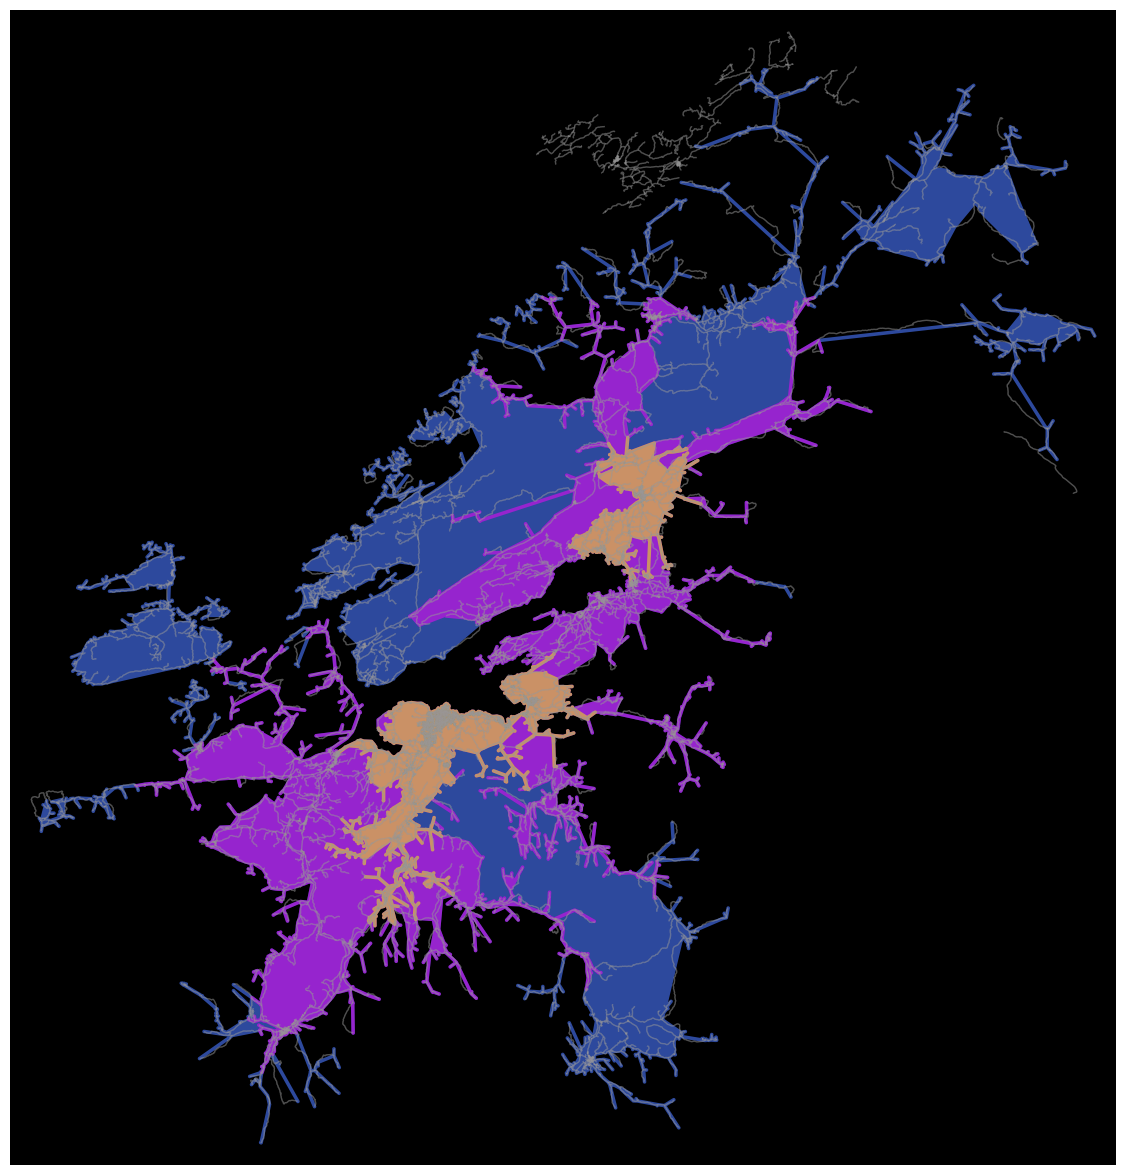

In [68]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Trondelag_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [69]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Trondelag_graph_increased, TRIP_TIMES, merged_isochrones, Trondelag_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 812 ms
Wall time: 972 ms
